In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from evaluate_utils import *
from sklearn.metrics import f1_score

##### 加载数据

In [2]:
train_previous_increase_ratio = np.load("../data/interim/stock500_2023_2024_previous_increase_ratio.npz")["previous_increase_ratio"]
train_post_increase_ratio = np.load("../data/interim/stock500_2023_2024_post_increase_ratio.npz")["post_increase_ratio"]
test_previous_increase_ratio = np.load("../data/interim/stock500_20250101_20250430_previous_increase_ratio.npz")["previous_increase_ratio"]
test_post_increase_ratio = np.load("../data/interim/stock500_20250101_20250430_post_increase_ratio.npz")["post_increase_ratio"]
valid_train_samples = (np.min(train_previous_increase_ratio, axis=1) > 0) & (np.min(train_post_increase_ratio, axis=1) > 0)
valid_test_samples = (np.min(test_previous_increase_ratio, axis=1) > 0) & (np.min(test_post_increase_ratio, axis=1) > 0)
train_previous_increase_ratio = train_previous_increase_ratio[valid_train_samples]
train_post_increase_ratio = train_post_increase_ratio[valid_train_samples]
test_previous_increase_ratio = test_previous_increase_ratio[valid_test_samples]
test_post_increase_ratio = test_post_increase_ratio[valid_test_samples]
# 数据标签
train_scores = np.max(train_post_increase_ratio, axis=1)
train_labels = np.max(train_post_increase_ratio, axis=1) >= 1.05
test_scores = np.max(test_post_increase_ratio, axis=1)
test_labels = np.max(test_post_increase_ratio, axis=1) >= 1.05
print("Shape of train_previous_increase_ratio: ", train_previous_increase_ratio.shape)
print("Shape of test_previous_increase_ratio: ", test_previous_increase_ratio.shape)
print("Shape of train_post_increase_ratio: ", train_post_increase_ratio.shape)
print("Shape of test_post_increase_ratio: ", test_post_increase_ratio.shape)
print("Number of positive samples in train data: ", train_labels.sum())
print("Number of positive samples in test data: ", test_labels.sum())

Shape of train_previous_increase_ratio:  (108998, 30)
Shape of test_previous_increase_ratio:  (22146, 30)
Shape of train_post_increase_ratio:  (108998, 5)
Shape of test_post_increase_ratio:  (22146, 5)
Number of positive samples in train data:  17986
Number of positive samples in test data:  5535


##### Nearest Neighbors

In [3]:
def knn(metric_name, k=50):
    knn = NearestNeighbors(n_neighbors=100, metric=f"{metric_name}")
    knn.fit(train_previous_increase_ratio)
    neighbors = knn.kneighbors(test_previous_increase_ratio, n_neighbors=k,return_distance=False)
    predictions = []
    for i in range(test_previous_increase_ratio.shape[0]):
        predictions.append(np.median(train_scores[neighbors[i]]))
    predictions = np.array(predictions)
    model_name = f"knn+{metric_name}"
    metrics = {"model_name": f"knn+{metric_name}"}
    auc = plot_roc_curve(predictions, test_labels, model_name)
    metrics["auc"] = auc
    precision_threshold_recall_dict = plot_precision_threshold_recall(predictions, test_labels, model_name)
    metrics.update(precision_threshold_recall_dict)
    metrics["f1_score"] = f1_score(test_labels, predictions > metrics["p50_th"])
    print(metrics["f1_score"])
    print(f"{metrics['f1_score']:.4f} {metrics['auc']:.4f} {metrics['p90_th']:.4f} {metrics['p90_re']:.4f} {metrics['p80_th']:.4f} {metrics['p80_re']:.4f} {metrics['p70_th']:.4f} {metrics['p70_re']:.4f} {metrics['p60_th']:.4f} {metrics['p60_re']:.4f} {metrics['p50_th']:.4f} {metrics['p50_re']:.4f}")

##### 策略1：knn+欧式距离

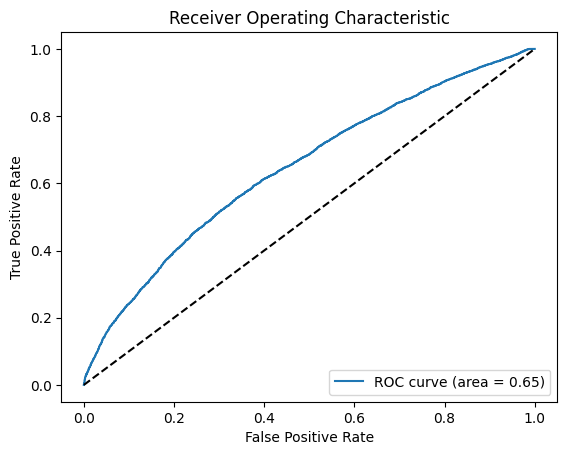

{'p90_th': 1.0908431381418082, 'p90_re': 0.0001806684733514002, 'p80_th': 1.0802853416086173, 'p80_re': 0.0005420054200542005, 'p70_th': 1.0509231550599032, 'p70_re': 0.019331526648599818, 'p60_th': 1.0446055271674228, 'p60_re': 0.04046973803071364, 'p50_th': 1.034604654860921, 'p50_re': 0.16513098464317977}


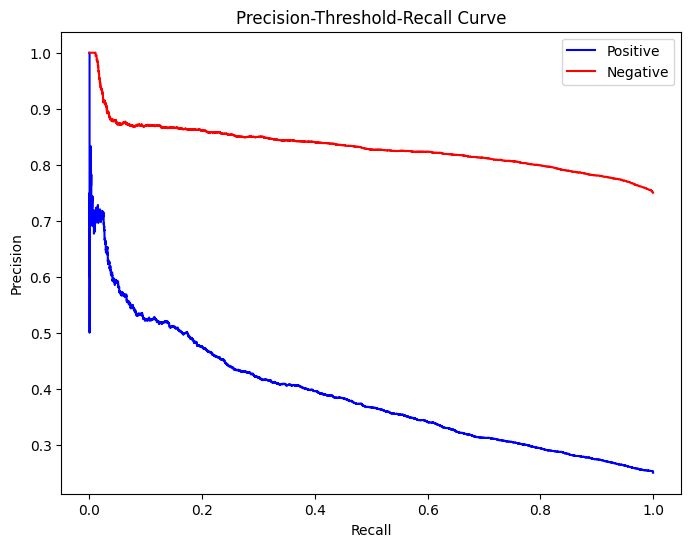

0.248099891422367
0.2481 0.6451 1.0908 0.0002 1.0803 0.0005 1.0509 0.0193 1.0446 0.0405 1.0346 0.1651


In [4]:
knn("euclidean", 50)

##### 策略2：knn+曼哈顿距离

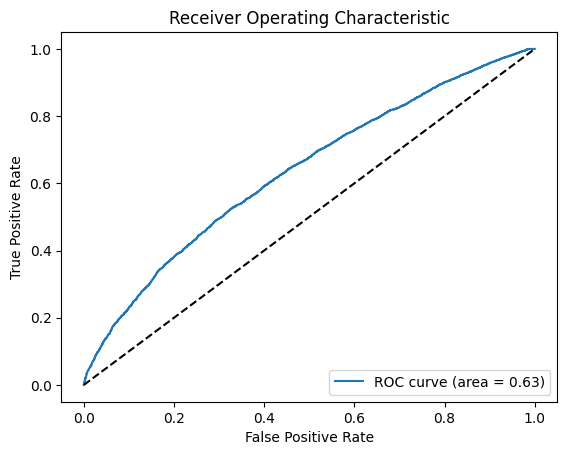

{'p90_th': 1.0924218073633525, 'p90_re': 0.0, 'p80_th': 1.0924218073633525, 'p80_re': 0.0, 'p70_th': 1.0762716755879185, 'p70_re': 0.0009033423667570009, 'p60_th': 1.0434393881403423, 'p60_re': 0.04336043360433604, 'p50_th': 1.0363645325866653, 'p50_re': 0.11291779584462511}


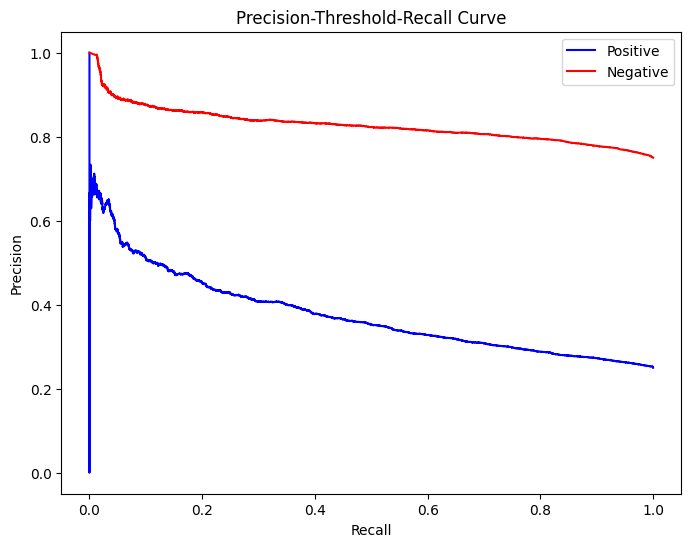

0.1841756298806542
0.1842 0.6348 1.0924 0.0000 1.0924 0.0000 1.0763 0.0009 1.0434 0.0434 1.0364 0.1129


In [5]:
knn("manhattan", 50)

策略3：knn+余弦相似度

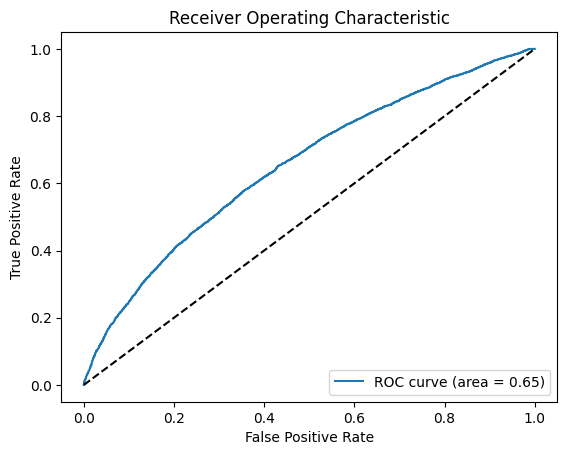

{'p90_th': 1.086220473637665, 'p90_re': 0.0007226738934056008, 'p80_th': 1.0861088385377449, 'p80_re': 0.0009033423667570009, 'p70_th': 1.05836435552678, 'p70_re': 0.01120144534778681, 'p60_th': 1.0478198287921372, 'p60_re': 0.026016260162601626, 'p50_th': 1.0344833723166933, 'p50_re': 0.17326106594399276}


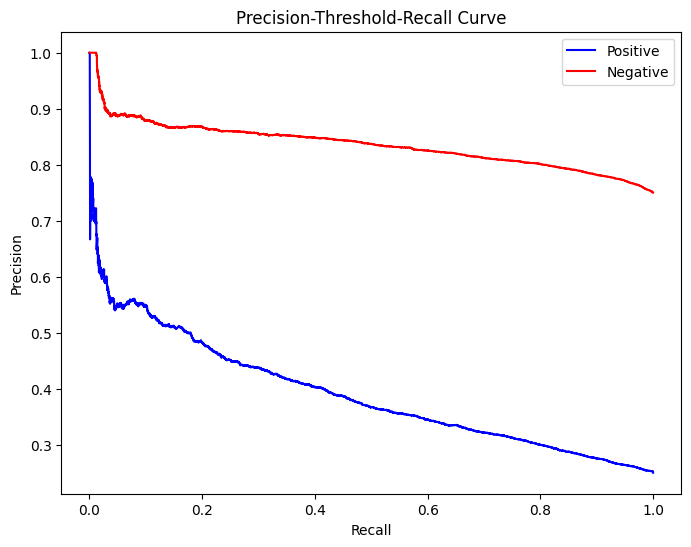

0.25727699530516435
0.2573 0.6526 1.0862 0.0007 1.0861 0.0009 1.0584 0.0112 1.0478 0.0260 1.0345 0.1733


In [6]:
knn("cosine", 50)

##### 策略四：knn+DTW

100
200
300
400
500
600
700
800
900


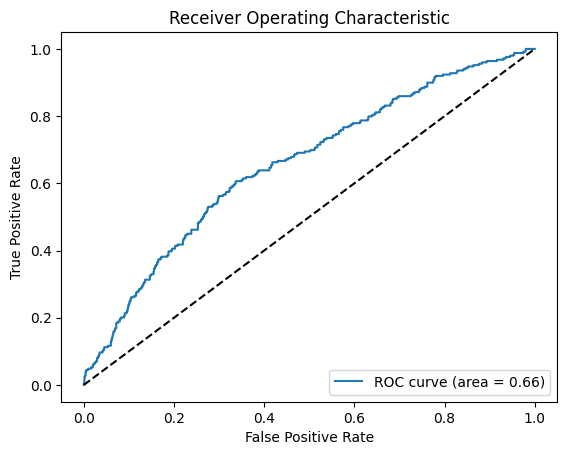

{'p90_th': 1.072078318124511, 'p90_re': 0.004016064257028112, 'p80_th': 1.0666229281852802, 'p80_re': 0.012048192771084338, 'p70_th': 1.0569823584364464, 'p70_re': 0.040160642570281124, 'p60_th': 1.0523201026531608, 'p60_re': 0.04819277108433735, 'p50_th': 1.0510905409147338, 'p50_re': 0.04819277108433735}


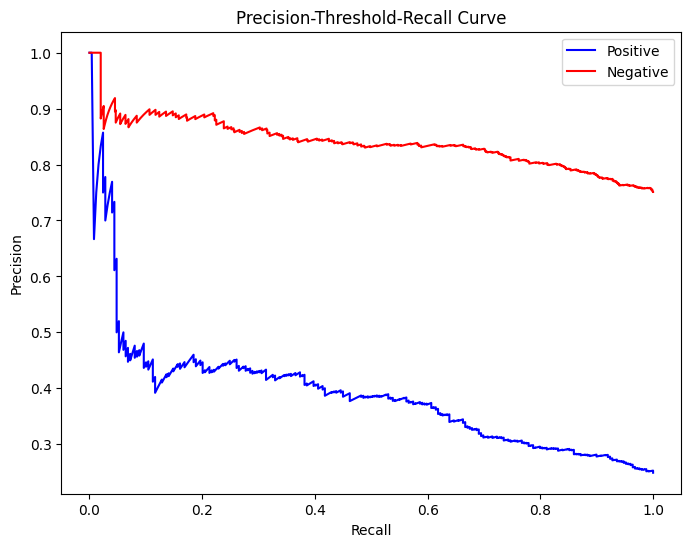

0.08791208791208792
0.0879 0.6566 1.0721 0.0040 1.0666 0.0120 1.0570 0.0402 1.0523 0.0482 1.0511 0.0482


In [7]:
from dtaidistance.dtw import distance_fast
from joblib import Parallel, delayed

metric_name = "dtw"
def compute_dtw(x, y):
    return distance_fast(x, y, use_c=True)

predictions = []
# dtw太慢了，所以只采样部分数据做
selected_train_indices = np.random.choice(train_previous_increase_ratio.shape[0], 100000, replace=False)
selected_test_indices = np.random.choice(test_previous_increase_ratio.shape[0], 1000, replace=False)
train_previous_increase_ratio2 = train_previous_increase_ratio[selected_train_indices]
test_previous_increase_ratio2 = test_previous_increase_ratio[selected_test_indices]
train_scores2 = train_scores[selected_train_indices]
test_labels2 = test_labels[selected_test_indices]
for i in range(test_previous_increase_ratio2.shape[0]):
    # 并行计算所有样本的DTW距离
    distances = Parallel(n_jobs=-1)(
        delayed(compute_dtw)(test_previous_increase_ratio2[i], y) for y in train_previous_increase_ratio2
    )
    # 获取最近的100个样本索引
    nearest_indices = np.argsort(distances)[:50]
    predictions.append(np.median(train_scores2[nearest_indices]))
    if i%100 == 0 and i > 0:
        print(i)
predictions = np.array(predictions)
model_name = f"knn+{metric_name}"
metrics = {"model_name": f"knn+{metric_name}"}
auc = plot_roc_curve(predictions, test_labels2, model_name)
metrics["auc"] = auc
precision_threshold_recall_dict = plot_precision_threshold_recall(predictions, test_labels2, model_name)
metrics.update(precision_threshold_recall_dict)
metrics["f1_score"] = f1_score(test_labels2, predictions > metrics["p50_th"])
print(metrics["f1_score"])
print(f"{metrics['f1_score']:.4f} {metrics['auc']:.4f} {metrics['p90_th']:.4f} {metrics['p90_re']:.4f} {metrics['p80_th']:.4f} {metrics['p80_re']:.4f} {metrics['p70_th']:.4f} {metrics['p70_re']:.4f} {metrics['p60_th']:.4f} {metrics['p60_re']:.4f} {metrics['p50_th']:.4f} {metrics['p50_re']:.4f}")